# Project Report

## Introduction

#### Background Information
A computer science research team led by Frank Wood is currently collecting data about how people play video games, specifically Minecraft. To do this, they set up a Minecraft server and meticulously record player actions and data, including their age, experience level, hours of play, whether the player is subscribed, and more. In general, there are three board questions the team is hoping to answer:

1. What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

2. We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

3. We are interested in demand forecasting, namely, what time windows are most likely to have a large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. 


#### Specific Question:

Can a KNN-Regression model use the variables experience, age, subscribe, and gender to predict played_hours in players.csv such that the RMSPE is no larger than 1.3 times the RMSE?

#### Dataset Description

##### The "Players" dataset contains 7 variables and 196 observations:
 
- __experience__ *(Character)*: How experienced the player is
- __hashedEmail__ *(Character)*: The player's email hashed
- __name__ *(Character)*: The name of the player
- __gender__ *(Character)*: The gender of the player
- __played_hours__ *(Double)*: How many hours the player played
- __Age__ *(Double)*: The age of the player
- __subscribe__ *(logical)*: If the player is subscribed


## Methods


In [1]:
# Loading in the Libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1234)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Loading Data: 

First, we started with loading our data. We loaded our data from the url "https://raw.githubusercontent.com/JasonCai0522/DSCI100_Datasets/refs/heads/main/players.csv" to ensure that ohers can run our notebook even without the dataset downloaded on their device.


In [2]:
# Loading in the data
player_data <- read_csv("https://raw.githubusercontent.com/JasonCai0522/DSCI100_Datasets/refs/heads/main/players.csv", show_col_types = FALSE)

#### Wrangling and Cleaning Data: 

To clean the data, we first decided to change the variables __experience__, and __gender__ from *character* type to *factor* type to more accurately reflect the data being represented. We also decided to drop all columns where the age is na to prevent issues in our model. Afterwards, we decided to select only the columns that were prevalent to our focus question (__experience__, __gender__, and __subscribe__, __played_hours__, __age__) to cut out unnecessary info in our dataframe.

In [3]:
# Changing data types
player_data_factor <- player_data |> 
        mutate(experience = as_factor(experience), gender = as_factor(gender)) |>
        rename(age = Age) |>
        drop_na(age)

# Selecting the relevent columns
player_data_tidy <- player_data_factor |>
        select(experience, subscribe, played_hours, gender, age)


Afterwards, since __experience__ and __gender__ are considered factor types, we decided to employ dummy coding to allow the KNN-Regression model to take them in. This means we added another column for each category in __experience__ and __gender__ with a binary value (0 or 1) to indicate whether it is part of that category. This allows us to use factor variables without directionality in our model. Finally, we changed __subscribe__ to be a binary value, with 0 representing false and 1 representing true. 

In [4]:
# Dummy coding experience and gender
# Experience values
pro_vals = ifelse(player_data_tidy$experience == 'Pro', 1, 0)
veteran_vals = ifelse(player_data_tidy$experience == 'Veteran', 1, 0)
regular_vals = ifelse(player_data_tidy$experience == 'Regular', 1, 0)
amateur_vals = ifelse(player_data_tidy$experience == 'Amateur', 1, 0)
beginner_vals = ifelse(player_data_tidy$experience == 'Beginner', 1, 0)

# Gender values
male_vals = ifelse(player_data_tidy$gender == 'Male', 1, 0)
female_vals = ifelse(player_data_tidy$gender == 'Female', 1, 0)
nb_vals = ifelse(player_data_tidy$gender == 'Non-binary', 1, 0)
agender_vals = ifelse(player_data_tidy$gender == 'Agender', 1, 0)
ts_vals = ifelse(player_data_tidy$gender == 'Two-Spirited', 1, 0)

player_data_dummy <- player_data_tidy |>
    mutate(pro = pro_vals, veteran = veteran_vals, regular = regular_vals, amateur = amateur_vals, beginner = beginner_vals) |>
    mutate(male = male_vals, female = female_vals, nb = nb_vals, agender = agender_vals, two_spirited = ts_vals) |>
    mutate(subscribe = ifelse(subscribe == TRUE, 1, 0)) |>
    select(-experience, -gender) 

player_data_dummy

subscribe,played_hours,age,pro,veteran,regular,amateur,beginner,male,female,nb,agender,two_spirited
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30.3,9,1,0,0,0,0,1,0,0,0,0
1,3.8,17,0,1,0,0,0,1,0,0,0,0
0,0.0,17,0,1,0,0,0,1,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,0.3,22,0,1,0,0,0,1,0,0,0,0
0,0.0,17,0,0,0,1,0,0,0,0,0,0
0,2.3,17,0,0,0,1,0,1,0,0,0,0


#### Summary of Data

Our next step is to summarize our data. To do this, we decided to summarize 5 important pieces of data to keep in mind while completing our analysis:
- The mean age of all participants
- The mean hours played of all participants
- How many people are subscribed and not subscribed
- The distribution of participants across genders
- The distribution of experience across all participants

In [5]:
mean_values <- summarize(player_data_dummy,
        mean_age = mean(age, na.rm = TRUE),
        mean_hours_played = mean(played_hours, na.rm = TRUE))

subscribe_count <- player_data_tidy |>
    group_by(subscribe) |> 
    summarize(count = n())

gender_count <- player_data_tidy |>
    group_by(gender) |> 
    summarize(count = n())

experience_count <- player_data_tidy |>
    group_by(experience) |> 
    summarize(count = n())

mean_values
subscribe_count
gender_count
experience_count

mean_age,mean_hours_played
<dbl>,<dbl>
20.52062,5.904639


subscribe,count
<lgl>,<int>
FALSE,52
TRUE,142


gender,count
<fct>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Agender,2
Two-Spirited,5


experience,count
<fct>,<int>
Pro,13
Veteran,48
Amateur,63
Regular,35
Beginner,35


#### Visualizing Data


visualizing data

### Data Analysis
To analyze our data, we decided to train a KNN-Regression model. Our reasoning for this is that we are attempting to predict a numerical value, which necessitates the use of either linear regression or KNN-Regression. From our visualization, we did not see a clear linear relationship. Additionally, the dataset is not that large, with only 194 observations, which is good for KNN-Regressions. 

To train our model, we first split our dataset into a test set and a train set. We decided to use a 75-25 train-test split for our model.

In [6]:
# Splitting data into train and test
players_split <- initial_split(player_data_dummy, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

Next, we created our recipe and model. Due to KNN-Regression calculating error from euclidean distance, scaling and centering is necessary to prevent variables with larger ranges contributing more to the distance calculation and over-influencing the prediction. 

In [7]:
# Creating recipe and spec
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

players_recipe <- recipe(played_hours ~ ., data = player_data_dummy) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())


Afterwards, we trained our model on k values from 1 to 100. We utilized 5-fold cross validation to provide a better estimate of model accuracy. Then, we collected the metrics for each k value.

In [8]:
players_vfold = vfold_cv(players_training, v = 5, strata = played_hours)
players_workflow <- workflow() |>
        add_recipe(players_recipe) |>
        add_model(players_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

players_results <- players_workflow |>
        tune_grid(resamples = players_vfold, grid = gridvals) |>
        collect_metrics()

players_results

→ A | warning: !  The following column has zero variance so scaling cannot be used: agender.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,40.504940693,5,9.2590472327,Preprocessor1_Model001
1,rsq,standard,0.003661718,5,0.0004505061,Preprocessor1_Model001
2,rmse,standard,34.192008775,5,7.5815420461,Preprocessor1_Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,rsq,standard,0.06311706,5,0.02605157,Preprocessor1_Model099
100,rmse,standard,27.31597852,5,8.36739403,Preprocessor1_Model100
100,rsq,standard,0.06261832,5,0.02507421,Preprocessor1_Model100


We found the k-val with the lowest RMSE value next, which turned out to be 6.

In [9]:
players_rmse <- players_results |>
        filter(.metric == "rmse") 

players_min <- players_rmse |> 
        slice_min(std_err)
players_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,rmse,standard,30.39263,5,6.746096,Preprocessor1_Model006


To get a better sense of how our model performed across different k-vals, we decided to graph k-val vs RMSE.

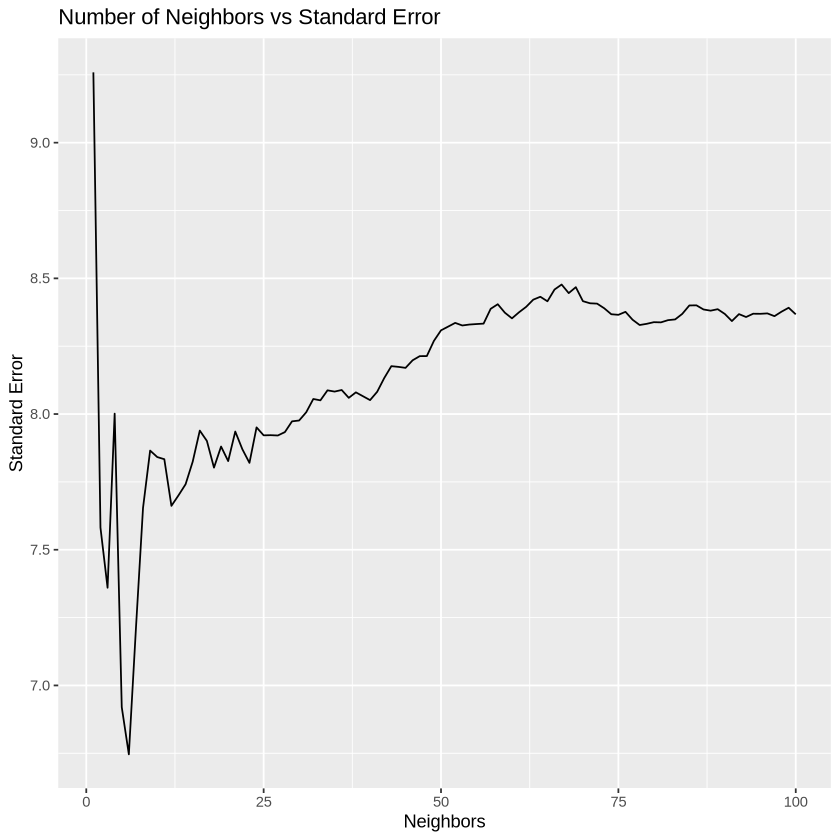

In [10]:
players_rmse |> 
    ggplot(aes(x = neighbors, y = std_err)) +
    geom_line() +
    labs(x = "Neighbors", y = "Standard Error", title = "Number of Neighbors vs Standard Error")

Continuing, we decided to make a prediction on our test set. We did this using the k-val with the minimum RMSE we got from previous steps. After making the prediction, we look at the metrics again to see our RMSPE value.

In [11]:
k_min <- players_min |>
         pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

players_best_fit <- workflow() |>
         add_recipe(players_recipe) |>
         add_model(players_best_spec) |>
         fit(data = players_training)

players_preds <- players_best_fit |>
          predict(players_testing) |>
          bind_cols(players_testing) 

players_summary <- players_preds |>
          metrics(truth = played_hours, estimate = .pred)

players_summary


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.541500e+01
rsq,standard,2.266247e-04
mae,standard,7.135714e+00


Finally, we plotted the predicted time against the age of the participants. Note that due to our KNN-Regression model using many predictor variables, it is difficult to visualize what the prediction line actually looks like. 

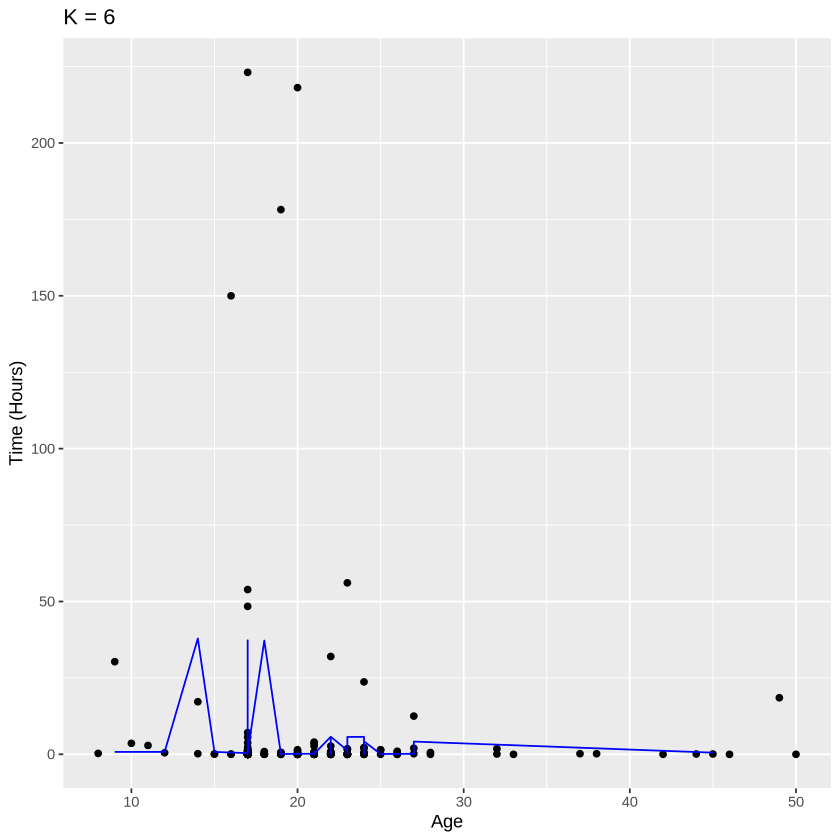

In [12]:
players_plot <- ggplot(player_data_dummy, aes(x = age, y = played_hours)) + 
        geom_point() + 
        geom_line(data = players_preds,
                 mapping = aes(x = age, y = .pred),
                 color = "blue") +
        labs(x = "Age", y = "Time (Hours)") + 
        ggtitle("K = 6")

players_plot